In [ ]:
# !pip install torchreid
# !pip install gdown

# # # #or 

# # # Install torchreid library
# !git clone https://github.com/ZobayerAbedin/deep-person-reid.git
# !pip install -r deep-person-reid/requirements.txt
# !pip install -v --no-cache-dir ./deep-person-reid

In [10]:
import torch
import torch.nn as nn
import torchreid
import os
import glob
import re
from torchreid.data.datasets import ImageDataset

2025-09-15 06:55:32.375009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757919332.397732      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757919332.404713      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
torch.cuda.empty_cache() # to clear the gpu cache [not necessary]

To see the list of all available models in the Torchreid library, you can use the `show_avai_models()` function. This function prints out the names of all models that you can use for person re-identification tasks.

In [ ]:
# torchreid.models.show_avai_models() 

In [ ]:
# !rm -rf /kaggle/working/log

# Step 2: Loading the Data

In [11]:
!rm -rf /kaggle/working/reid-data
!mkdir  /kaggle/working/reid-data
!mkdir  /kaggle/working/reid-data/market1501_v3

In [12]:
!cp -r /kaggle/input/market-v3/market1501-v3 -d /kaggle/working/reid-data/market1501_v3

In [4]:
# !rm -rf /kaggle/working/log

In [13]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os
import os.path as osp
import glob
import re

from torchreid.data.datasets import ImageDataset

class market1501_v3(ImageDataset):
    dataset_dir = 'market1501_v3/market1501-v3'

    def __init__(self, root='', **kwargs):
        self.root = os.path.abspath(os.path.expanduser(root))
        self.dataset_dir = os.path.join(self.root, self.dataset_dir)

        train, query, gallery = self._process_dir(self.dataset_dir)

        super(market1501_v3, self).__init__(train, query, gallery, **kwargs)

    def _process_dir(self, dir_path):
        train_dir = os.path.join(dir_path, 'bounding_box_train')
        query_dir = os.path.join(dir_path, 'query')
        gallery_dir = os.path.join(dir_path, 'bounding_box_test')

        train = self._process_image_dir(train_dir, relabel=True)
        query = self._process_image_dir(query_dir, relabel=False)
        gallery = self._process_image_dir(gallery_dir, relabel=False)
        
        return train, query, gallery

    def _process_image_dir(self, dir_path, relabel=False):
        img_paths = glob.glob(os.path.join(dir_path, '*.jpg'))
        pattern = re.compile(r'([-\d]+)_c(\d)')
        
        pid_container = set()
        for img_path in img_paths:
            pid, _ = map(int, pattern.search(img_path).groups())
            if pid == -1: continue  # junk images are just ignored
            pid_container.add(pid)
        
        pid2label = {pid: label for label, pid in enumerate(pid_container)}

        data = []
        for img_path in img_paths:
            pid, camid = map(int, pattern.search(img_path).groups())
            if pid == -1: continue  # junk images are just ignored
            assert 0 <= pid <= 1501  # pid == 0 means background
            assert 0 <= camid <= 6
            camid -= 1  # index starts from 0
            if relabel: pid = pid2label[pid]
            data.append((img_path, pid, camid))
            
        return data

torchreid.data.register_image_dataset('market1501_v3', market1501_v3)



In [ ]:
import torchreid.data.datasets

del torchreid.data.datasets.__image_datasets['market1501_v3']

You can initialize an ImageDataManager and automatically download datasets. However, connections might time out and I faced the error of not being able to download the data. 

In [ ]:
# # Create the required directory structure

# !mkdir /kaggle/working/reid-data
# !mkdir /kaggle/working/reid-data/market1501

In [ ]:
#Copy and extract the dataset to the working directory

# !cp -r /kaggle/input/market-1501-v15-09-15/Market-1501-v15.09.15 -d /kaggle/working/reid-data/market1501

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    !nvidia-smi
print(device)

Mon Sep 15 07:00:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

The `torchreid.data` module provides tools for managing datasets in person re-identification tasks. The `DataManager` and `ImageDataManager` classes are essential for handling data loading, transformations, and preprocessing.

Check more [here](https://kaiyangzhou.github.io/deep-person-reid/pkg/data.html#module-torchreid.data.datamanager)

In [14]:
datamanager = torchreid.data.ImageDataManager(
    root='/kaggle/working/reid-data',  # updated root directory
    sources='market1501_v3',
    height=256,
    width=128,
    batch_size_test=256,
    batch_size_train=64,
    market1501_500k=False,
    combineall=False,
)

Building train transforms ...
+ resize to 256x128
+ random flip
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building test transforms ...
+ resize to 256x128
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
=> Loading train (source) dataset
=> Loaded market1501_v3
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    19753 |         7
  query    |   750 |     5137 |         7
  gallery  |   751 |    23171 |         7
  ----------------------------------------
=> Loading test (target) dataset
=> Loaded market1501_v3
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    19753 |         7
  query    |   750 |     5137 |         7
  gallery  |   751 |    23171 |         7
  -------

Note that the ImageDataManager won't recognize the already present data if the directory structure and the directories name don't match. If it doesn't recognize then it'll proceed to download the data. 

# Step 3: Setting Up the Training Engine with Torchreid

In [ ]:
# torchreid.models.show_avai_models()

We build a model using the osnet_x1_0 architecture, which is specifically designed for re-identification tasks.
The model is set to classify the number of unique person IDs in the training data.


The Adam optimizer is used with a learning rate of 0.0003, which helps in updating the model weights during training.

A single-step scheduler is used to adjust the learning rate after every 10 epochs to help the model converge.

In [17]:
model = torchreid.models.build_model(
    name= "resnet152",
    num_classes=datamanager.num_train_pids,
    loss="softmax",
    pretrained=True
)

model = model.to(device)

optimizer = torchreid.optim.build_optimizer(
    model,
    optim="adam",
    lr=0.0003
)

scheduler = torchreid.optim.build_lr_scheduler(
    optimizer,
    lr_scheduler="single_step",
    stepsize=10
)

In [18]:
engine = torchreid.engine.ImageSoftmaxEngine(
    datamanager,
    model,
    optimizer=optimizer,
    scheduler=scheduler,
    label_smooth=True
)

In [ ]:
engine.datamanager

For now, I'll try it only for one epoch.

In [19]:
engine.run(
    save_dir="log/osnet_x1_0",
    max_epoch=15,
    eval_freq=5,
    print_freq=300,
    test_only=False
)

=> Start training
epoch: [1/15][300/308]	time 0.478 (0.484)	data 0.000 (0.003)	eta 0:34:51	loss 3.4232 (5.3054)	acc 46.8750 (12.5521)	lr 0.000300
epoch: [2/15][300/308]	time 0.478 (0.480)	data 0.000 (0.002)	eta 0:32:04	loss 2.1054 (2.5178)	acc 78.1250 (63.8906)	lr 0.000300
epoch: [3/15][300/308]	time 0.478 (0.480)	data 0.001 (0.002)	eta 0:29:36	loss 1.7651 (1.7937)	acc 81.2500 (84.7031)	lr 0.000300
epoch: [4/15][300/308]	time 0.479 (0.480)	data 0.000 (0.002)	eta 0:27:10	loss 1.4900 (1.5675)	acc 93.7500 (90.7240)	lr 0.000300
epoch: [5/15][300/308]	time 0.478 (0.480)	data 0.000 (0.002)	eta 0:24:43	loss 1.6105 (1.4562)	acc 81.2500 (93.4010)	lr 0.000300
##### Evaluating market1501_v3 (source) #####
Extracting features from query set ...
Done, obtained 5137-by-2048 matrix
Extracting features from gallery set ...
Done, obtained 23171-by-2048 matrix
Speed: 0.0330 sec/batch
Computing distance matrix with metric=euclidean ...
Computing CMC and mAP ...
** Results **
mAP: 51.7%
CMC curve
Rank-1  

In [ ]:
engine.run(
    save_dir="log/osnet_x1_0",
    max_epoch=10,
    eval_freq=1,
    print_freq=300,
    test_only=False
)

In [ ]:
engine.run(
   test_only=True
)

Available scalar tags: ['Train/time', 'Train/data', 'Train/loss', 'Train/acc', 'Train/lr', 'Test/market1501_v3/rank1', 'Test/market1501_v3/mAP']


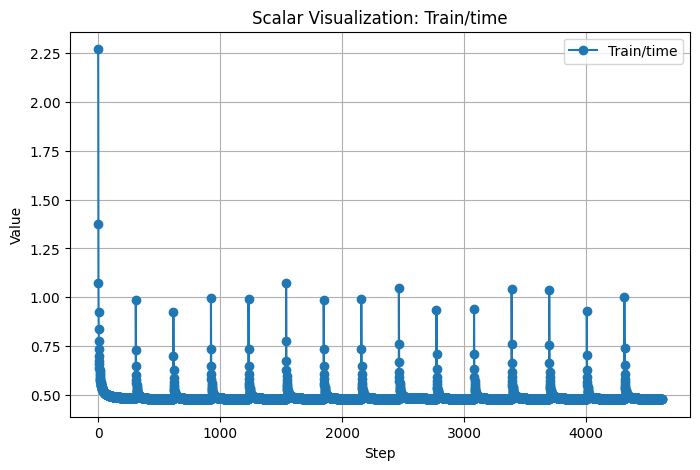

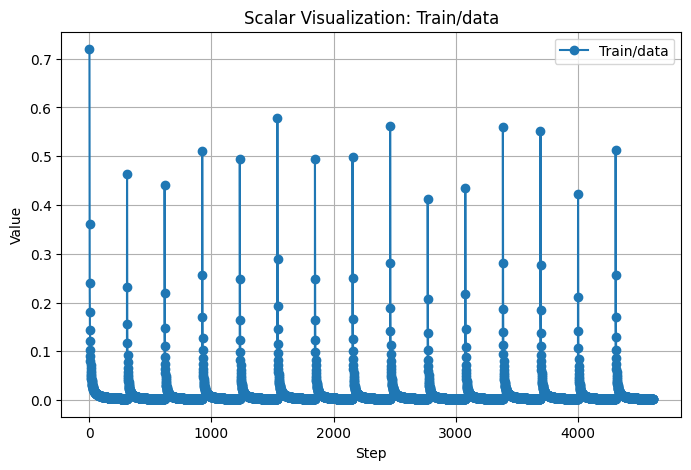

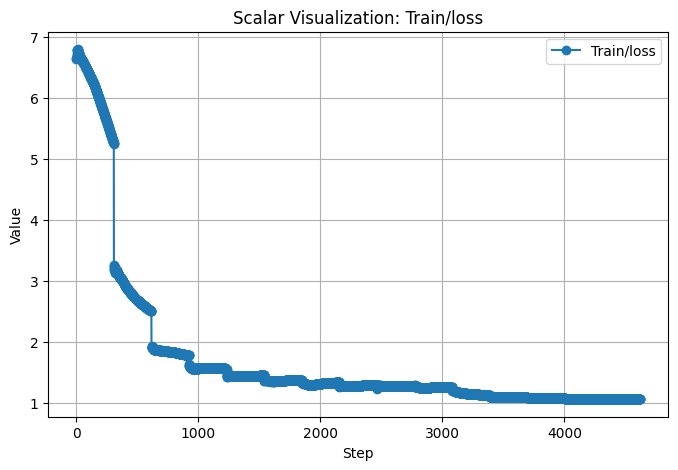

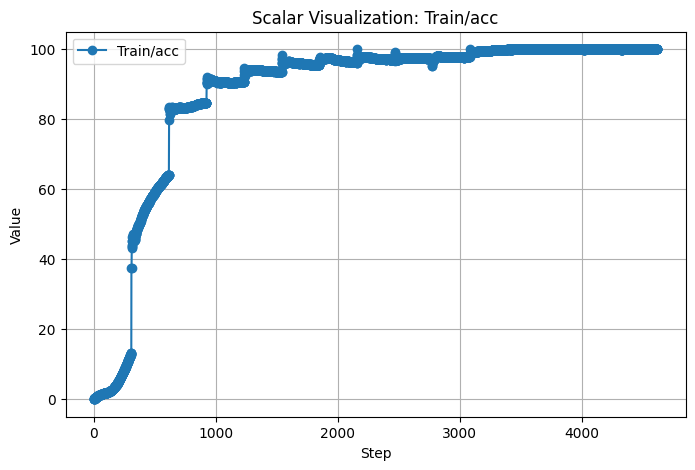

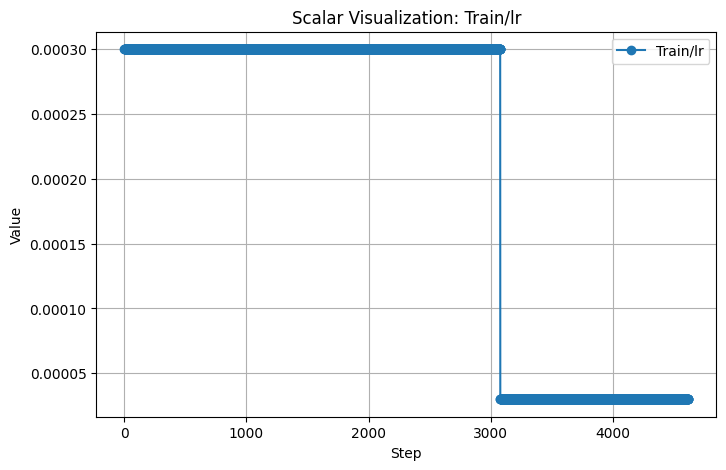

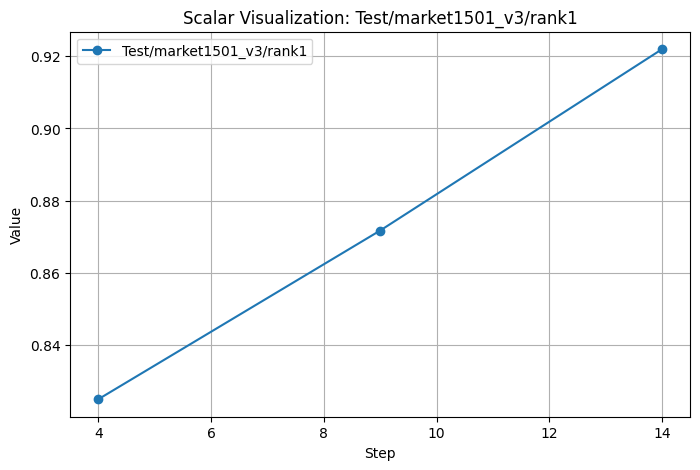

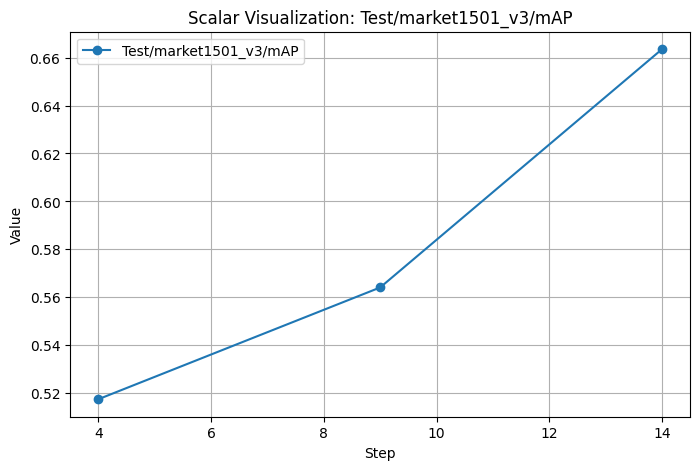

In [25]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os

# Path to your event file
event_file = "/kaggle/working/log/osnet_x1_0/events.out.tfevents.1757919784.ce250bf0452b.36.0"

# Load event file
ea = event_accumulator.EventAccumulator(event_file)
ea.Reload()

# Get all scalar tags
tags = ea.Tags()["scalars"]
print("Available scalar tags:", tags)

# Plot each scalar tag
for tag in tags:
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    plt.figure(figsize=(8,5))
    plt.plot(steps, values, marker="o", label=tag)
    plt.xlabel("Step")
    plt.ylabel("Value")
    plt.title(f"Scalar Visualization: {tag}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [20]:
# # Define the path to save the model
# save_path = '/kaggle/working/model_osnet_x1_1.pth'

# # Create a dictionary to save all relevant information
# checkpoint = {
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
#     'epoch': 10
# }

# # Save the checkpoint
# torch.save(checkpoint, save_path)
# print(f"Model saved to {save_path}")

Model saved to /kaggle/working/model_osnet_x1_1.pth


In [ ]:
# If loading on specific GPU
save_path = '/kaggle/working/model_osnet_x1_1.pth'
checkpoint = torch.load(save_path, map_location='cuda:0')
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
!rm -rf /kaggle/working/reid-data/market1501_v3/market1501-v3/bounding_box_train
!rm -rf /kaggle/working/reid-data/market1501_v3/market1501-v3/query

In [ ]:
!cp -r /kaggle/input/market-test-v1/market1501-test-v1/bounding_box_test -d /kaggle/working/reid-data/market1501_v3/market1501-v3/bounding_box_train
!cp -r /kaggle/input/market-test-v1/market1501-test-v1/query -d /kaggle/working/reid-data/market1501_v3/market1501-v3/query

In [ ]:
engine.run(
    save_dir='res',
    test_only=True,
    visrank=True,
    visrank_topk=5
)

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the directory containing the images
image_dir = '/kaggle/working/res/visrank_market1501_v3'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Check if there are any images in the directory
if not image_files:
    print("No image files found in the directory.")
else:
    # Loop through each image and display it
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        img = mpimg.imread(image_path)
        
        # Create a new figure for each image
        plt.figure(figsize=(26, 1))
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')  # Hide axes
        plt.show()

In [ ]:
!dir log/osnet/visrank_market1501

# Step 4: Visualizing Results and Activation Maps 
This script helps visualize the results and the activation maps of the model to understand what parts of the image the model is focusing on.


In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Define the directory containing the images
image_dir = 'log/osnet/visrank_market1501'

# List all files in the directory
all_images = os.listdir(image_dir)

# Filter to include only image files (if necessary)
image_files = [f for f in all_images if f.endswith(('.jpg', '.jpeg', '.png'))]

# Number of images to display
num_images = 5

# Randomly select a subset of images
selected_images = random.sample(image_files, num_images)

# Calculate grid size (2x3 grid for 5 images)
cols = 2
rows = (num_images + 1) // cols

# Create a figure for displaying images
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array if more than one row
if rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Loop through the selected image paths and display them
for idx, img_file in enumerate(selected_images):
    # Define the full path to the image
    img_path = os.path.join(image_dir, img_file)
    
    # Open the image using PIL
    image = Image.open(img_path)

    # Display the image
    axes[idx].imshow(image)
    axes[idx].axis('off')  # Hide the axis
    axes[idx].set_title(f"Image {idx+1}")

# Remove any empty subplots
for ax in axes[num_images:]:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the image
image_path = 'log/osnet/visrank_market1501/0530_c3s1_149183_00.jpg'

# Open the image using PIL
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


In [ ]:
# Define the path to the dataset and model weights
dataset_root = '/kaggle/input/market-1501-v15-09-15/Market-1501-v15.09.15'
save_dir = 'log/visactmap_osnet_x1_0_market1501'

In [ ]:
import warnings
warnings.filterwarnings("ignore") 

In [ ]:
# Set the model to evaluation mode
model.eval()
model = model.to(device)

from torchvision import transforms
import numpy as np

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess an image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension
    return img

# Function to visualize activation maps
def visualize_activation_maps(model, image_paths, save_dir):
    for img_path in image_paths:
        # Preprocess the image
        img = preprocess_image(img_path).to(device)

        # Forward pass to get feature maps
        with torch.no_grad():
            feature_maps = model(img, return_featuremaps=True)
        
        # Get the activation map
        activation_map = torch.mean(feature_maps, dim=1).squeeze().cpu().numpy()
        
        # Normalize the activation map
        activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
        
        # Resize the activation map to match the input image size
        activation_map = Image.fromarray(np.uint8(activation_map * 255)).resize((128, 256), Image.BILINEAR)
        activation_map = np.array(activation_map) / 255.0
        
        # Load the original image
        img = Image.open(img_path).convert('RGB')
        img = np.array(img.resize((128, 256)))
        
        # Plot the original image, activation map, and overlapped image
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        axes[1].imshow(activation_map, cmap='jet')
        axes[1].set_title("Activation Map")
        axes[1].axis('off')
        
        overlapped_img = (img * 0.6 + plt.cm.jet(activation_map)[..., :3] * 0.4 * 255).astype(np.uint8)
        axes[2].imshow(overlapped_img)
        axes[2].set_title("Overlapped Image")
        axes[2].axis('off')
        
        # Save the figure
        save_path = os.path.join(save_dir, os.path.basename(img_path))
        plt.savefig(save_path)
        plt.close()
        print(f"Saved activation map for {img_path} to {save_path}")

# Paths to some images for visualization
image_paths = [
    '/kaggle/working/reid-data/market1501/Market-1501-v15.09.15/bounding_box_test/-1_c1s1_011426_05.jpg',
]  # Add your image paths here



# Visualize activation maps
visualize_activation_maps(model, image_paths, save_dir)